In [1]:
import copy
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import re

import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(display_expand_data=False)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook',palette='bright',style='ticks')

from tqdm.auto import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.figure_formats = ['svg']

In [3]:
from AFL.double_agent.AgentClient import AgentClient
from AFL.automation.APIServer.Client import Client

In [4]:
import sasmodels.data

from tiled.client import from_uri
from tiled.queries import Eq,Contains

# Test data from 23-05 PSI

In [5]:
path = '//mnt/c/Users/drs18/Downloads/230530_AL_manifest-P188_2D_MultiModal_UCB_noThomp_FixedP188.nc'
ds_psi = xr.load_dataset(path)
ds_psi

<xarray.Dataset>
Dimensions:                      (sample: 33, q: 500, wavelength: 2048)
Coordinates:
  * q                            (q) float64 0.009814 0.01036 ... 0.2791 0.2796
  * wavelength                   (wavelength) float64 180.8 181.2 ... 867.9
Dimensions without coordinates: sample
Data variables: (12/20)
    fname                        (sample) <U67 'AL_P188_2D_MultiModal_UCB_noT...
    SAS                          (sample, q) float64 679.3 676.8 ... 40.92 40.92
    turbidity                    (sample) float64 -0.9926 -0.9915 ... -0.9888
    spec                         (sample, wavelength) float64 0.0 96.0 ... 116.0
    spec_error                   (sample, wavelength) float64 0.0 1.0 ... 3.0
    label                        (sample) int64 -1 -1 -1 -1 -1 ... -1 -1 -1 -1
    ...                           ...
    mfrac_benzyl_alcohol_solute  (sample) float64 0.004425 0.004405 ... 0.004609
    mass_benzyl_alcohol_solute   (sample) float64 5.0 5.0 5.0 ... 6.122 5.204
    mfrac_phenol_solute          (sample) float64 0.004425 0.008811 ... 0.003524
    mass_phenol_solute           (sample) float64 5.0 10.0 15.0 ... 3.673 3.98
    mfrac_D2O                    (sample) float64 0.9823 0.978 ... 0.9825 0.983
    mass_D2O                     (sample) float64 1.11e+03 1.11e+03 ... 1.11e+03
Attributes: (12/30)
    components:                        ['P188', 'benzyl_alcohol_solute', 'phe...
    P188_range:                        [10.  10.1]
    benzyl_alcohol_solute_range:       [ 0 15]
    phenol_solute_range:               [ 0 15]
    P188_npts:                         1
    benzyl_alcohol_solute_npts:        50
    ...                                ...
    SAS_savgol_npts:                   250
    SAS_savgol_window_length:          31
    SAS_savgol_polyorder:              2
    SAS_savgol_logx:                   1
    SAS_savgol_logy:                   1
    AL_data:                           SAS

# Load Starting Data

In [17]:
dataset=xr.load_dataset('regressor_and_classifier_data.nc')
tf = dataset.sans_fit_values.notnull()
# dataset = dataset.dropna(dim='sans_sample')
dataset

<xarray.Dataset>
Dimensions:              (sans_q: 500, sans_sample: 33, component: 2)
Coordinates:
  * sans_q               (sans_q) float64 0.009814 0.01036 ... 0.2791 0.2796
  * component            (component) <U21 'benzyl_alcohol_solute' 'phenol_sol...
Dimensions without coordinates: sans_sample
Data variables:
    sans                 (sans_sample, sans_q) float64 679.3 676.8 ... 40.92
    sans_err             (sans_sample, sans_q) float64 67.93 67.68 ... 4.092
    sans_comps           (sans_sample, component) float64 5.0 5.0 ... 5.204 3.98
    sans_labels          (sans_sample) int64 0 1 1 2 2 2 2 2 ... 2 2 2 0 0 2 0 2
    sans_label_names     (sans_sample) <U17 'polymer_micelle_1' ... 'poly_gau...
    sans_best_chisq      (sans_sample) float64 0.109 0.36 ... 0.1711 0.157
    sans_fit_values      (sans_sample) float64 18.67 nan nan ... nan 25.91 nan
    sans_fit_err_values  (sans_sample) float64 0.7912 nan nan ... nan 1.14 nan

In [18]:
# dataset=xr.load_dataset('regressor_and_classifier_data.nc')
# display(dataset)
# dataset['sans_fit_values'] = dataset.sans_fit_values.dropna(dim='sans_sample')#.swap_dims({'sans_sample':'saxs_sample'})
# dataset['sans_fit_err_values'] = dataset.sans_fit_err_values.dropna(dim='sans_sample')#.swap_dims({'sans_sample':'saxs_sample'})
# display(dataset)
dataset['sans_comps'] = xr.DataArray(
    np.array([ds_psi.benzyl_alcohol_solute,ds_psi.phenol_solute]).T,#[tf],
    dims=['sans_sample','component'],
    coords={'component':['benzyl_alcohol_solute','phenol_solute']}
)


#mismatching the comps
dataset['saxs_comps'] = xr.DataArray(
    np.array([ds_psi.phenol_solute,ds_psi.benzyl_alcohol_solute]).T,
    dims=['saxs_sample','component'],
    coords={'component':['benzyl_alcohol_solute','phenol_solute']}
)

dataset['sans'] = xr.DataArray(
    ds_psi.SAS.values,#[tf], 
    dims=['sans_sample','sans_q'],
    coords={'sans_q':ds_psi.q.values}
   )

dataset['saxs'] = xr.DataArray(
    ds_psi.SAS.values, 
    dims=['saxs_sample','saxs_q'],
    coords={'saxs_q':ds_psi.q.values}
   )

dataset['sans_err'] = xr.DataArray(
    0.1 * ds_psi.SAS.values,#[tf], 
    dims=['sans_sample','sans_q']
   )

dataset['saxs_err'] = xr.DataArray(
    0.1 * ds_psi.SAS.values, 
    dims=['saxs_sample','saxs_q']
   )

dataset = dataset.drop_vars(['sans_labels','sans_label_names','sans_best_chisq','sans_fit_values','sans_fit_err_values'])
# dataset = dataset.rename_vars(
#     {'sans_fit_values':'rg',
#     'sans_fit_err_values':'rg_err'}
# )
dataset

<xarray.Dataset>
Dimensions:     (sans_q: 500, sans_sample: 33, component: 2, saxs_sample: 33,
                 saxs_q: 500)
Coordinates:
  * sans_q      (sans_q) float64 0.009814 0.01036 0.0109 ... 0.2791 0.2796
  * component   (component) <U21 'benzyl_alcohol_solute' 'phenol_solute'
  * saxs_q      (saxs_q) float64 0.009814 0.01036 0.0109 ... 0.2791 0.2796
Dimensions without coordinates: sans_sample, saxs_sample
Data variables:
    sans        (sans_sample, sans_q) float64 679.3 676.8 669.5 ... 40.92 40.92
    sans_err    (sans_sample, sans_q) float64 67.93 67.68 66.95 ... 4.092 4.092
    sans_comps  (sans_sample, component) float64 5.0 5.0 5.0 ... 5.204 3.98
    saxs_comps  (saxs_sample, component) float64 5.0 5.0 10.0 ... 3.98 5.204
    saxs        (saxs_sample, saxs_q) float64 679.3 676.8 669.5 ... 40.92 40.92
    saxs_err    (saxs_sample, saxs_q) float64 67.93 67.68 66.95 ... 4.092 4.092

# Multi-Modal pipeline

In [19]:
from AFL.double_agent import *
from AFL.double_agent import SASfit
from SAS_model_fit_driver import sas_wrapper
from sklearn import gaussian_process

## initial SAS model dict

In [20]:
initial_models = [
    {'name':"polymer_micelle_1",
     'sasmodel':'polymer_micelle',
     'fit_params':{
            "scale"       : {'value':600, 'bounds':(1e-1,1e4)},
            "background"  : {'value':50,       'bounds':(1e-1,1e4)},
            "radius_core" : {'value':40,       'bounds':(1e-1,1e4)},
            "rg"          : {'value':60,       'bounds':(1e-1,1e4)},
            "sld_core"    : {'value':5.45,     'bounds':None},
            "sld_corona"  : {'value':5.15,     'bounds':None},
            "sld_solvent" : {'value':6.36,     'bounds':None},
     }
    },
    {'name':"small_sphere_1",
     'sasmodel':'sphere',
     'fit_params':{
            "scale"       : {'value':350,   'bounds':(1e-1,1e4)},
            "background"  : {'value':20,       'bounds':(1e1,1e2)},
            "radius"      : {'value':50,       'bounds':(1e-1,1e3)},
            "radius_pd"   : {'value':0.15,       'bounds':(0.02,0.5)},
            "radius_pd_type": {'value':'gaussian','bounds':None},
            "radius_pd_n": {'value':15,'bounds':None},
            "sld"         : {'value':5.45,     'bounds':None},
            "sld_solvent" : {'value':6.36,     'bounds':None},
        }
    },
    {'name':"poly_gauss_coil_1",
     'sasmodel':'poly_gauss_coil',
     'fit_params':{
            "i_zero"      : {'value':350,   'bounds':(1e-1,1e4)},
            "background"  : {'value':40,       'bounds':(1e-1,1e4)},
            "rg"          : {'value':60,       'bounds':(1e-1,1e4)},
            # "polydispersity": {'value':1,       'bounds':(0.5,2)}
        }
    }
]

## build pipeline

In [21]:
with Pipeline() as pline:
    # data preprocessing step (tbd, background suptraction etc.)
    Standardize(input_variable='sans_comps',
                    output_variable='sans_comps_standardized',
                    dim='sans_sample'
               )
    
    Standardize(input_variable='saxs_comps',
                    output_variable='saxs_comps_standardized',
                    dim='saxs_sample',
               )

    # run saxs classifier
    SASfit.SASfit_classifier(
        sas_variable='saxs',
        sas_err_variable='saxs_err',
        input_models=initial_models,
        resolution=None,
        output_prefix='saxs',
        q_dim = 'saxs_q',
        sample_dim='saxs_sample'
    )

    # run sans classifier
    SASfit.SASfit_classifier(
        sas_variable='sans',
        sas_err_variable='sans_err',
        input_models=initial_models,
        resolution=None,
        output_prefix='sans',
        q_dim = 'sans_q',
        sample_dim='sans_sample'
    )

    # # run sans regressor
    # SASfit.SASfit_fit_extract(
    #     sas_variable='sans',
    #     sas_err_variable='sans_err',
    #     input_models=initial_models,
    #     resolution=None,
    #     output_prefix='sans',
    #     q_dim = 'sans_q',
    #     sample_dim='sans_sample',
    #     target_model='polymer_micelle_1',
    #     target_fit_params='radius_core'
    # )
    
    # # preprocess Y to be z-scored
    # Zscale(input_variable='sans_fit_values',
    #        output_variable='sans_fit_values_zscaled',
    #        dim='sans_sample'
    #       )
    
    # # preprocess y_err to scale with the scaled Y
    # Zscale_error(input_variables=['sans_fit_values', 'sans_fit_err_values'],
    #              output_variable='sans_fit_err_values_zscaled',
    #              dim='sans_sample'
    #             )    
    
    # need to build grid object
    grid_spec = {
        'benzyl_alcohol_solute':{'min':0,'max':1,'steps':31},
        'phenol_solute':{'min':0,'max':1,'steps':31}
    }
    CartesianGrid(grid_spec=grid_spec, output_variable='sans_comps_grid',sample_dim='grid')

    CartesianGrid(grid_spec=grid_spec, output_variable='saxs_comps_grid',sample_dim='grid')

    #kernel needs to have the length scales in accordance with the input dimensions. if you standardize the inputs, your values should be between 0-1
    kernel = gaussian_process.kernels.Matern(length_scale=[0.1,0.2], nu=2.5,length_scale_bounds=[(1e-1,1e0),(1e-1,1e0)])
    # kernel = gaussian_process.kernels.Matern(length_scale=(3.,.1), nu=2.5, length_scale_bounds=[(1e-3,1e1),(1e-3,1e1)])
    
    # build GPC from saxs data
    GaussianProcessClassifier(
        kernel=kernel,
        optimizer=None,
        feature_input_variable='saxs_comps_standardized',
        predictor_input_variable='saxs_labels',
        output_prefix='saxs_labels_extrap',
        sample_dim='saxs_sample',
        grid_variable='saxs_comps_grid',
        grid_dim='grid',
    )

    # Z-scale the entropy that's returned from the GPC
    Zscale(input_variable='saxs_labels_extrap_entropy',
           output_variable='saxs_labels_extrap_entropy_zscaled',
           dim='sans_sample'
          )

    kernel = gaussian_process.kernels.Matern(length_scale=[0.3,0.1], nu=2.5,length_scale_bounds=[(1e-1,1e0),(1e-1,1e0)])
    GaussianProcessClassifier(
        kernel=kernel,
        optimizer=None,
        feature_input_variable='sans_comps_standardized',
        predictor_input_variable='sans_labels',
        output_prefix='sans_labels_extrap',
        sample_dim='sans_sample',
        grid_variable='sans_comps_grid',
        grid_dim='grid',
    )
    
    # # build GPR from sans data
    # GaussianProcessRegressor(
    #     kernel = kernel,
    #     # optimizer=None,
    #     feature_input_variable='sans_comps_standardized',
    #     predictor_input_variable='sans_fit_values_zscaled',
    #     predictor_uncertainty_variable='sans_fit_err_values_zscaled',
    #     output_prefix='sans_fit_values_extrap',
    #     grid_variable='sans_comps_grid',
    #     grid_dim='grid',
    #     sample_dim='sans_sample'
    # )
    
    # for classification vs. classification, one needs two GPC models and probably a better way to deal with the unique labels = 1
    # The problem is that the GPC won't work at all if there is only one label
    MaxValueAF(
        input_variables=['sans_labels_extrap_entropy','saxs_labels_extrap_entropy'],
        output_variable='next_samples_xy',
        grid_variable='sans_comps_grid',
        grid_dim='grid',
        decision_rtol=0.05,
        # excluded_comps_variables=['saxs_comps_xy','sans_comps_xy'],
        # excluded_comps_dim='xy',
        exclusion_radius=1e-3,
        count=1,
    )

    # # this is for blending the classification and regression data
    # PseudoUCB(
    #     input_variables=['sans_fit_values_extrap_mean', 'sans_fit_values_extrap_var','saxs_labels_extrap_entropy_zscaled'],
    #     lambdas = [0.5, 0.5, 0.5],
    #     output_variable='next_samples_xy',
    #     grid_variable='sans_comps_grid',
    #     grid_dim='grid',
    #     decision_rtol=0.05,
    #     # excluded_comps_variables=['saxs_comps_xy','sans_comps_xy'],
    #     # excluded_comps_dim='xy',
    #     exclusion_radius=1e-3,
    #     count=1,
    # )


pline
    

<Pipeline Pipeline N=10>

In [22]:
dataset_out = pline.calculate(dataset)

  0%|          | 0/10 [00:00<?, ?it/s]

/root/AFL-agent/AFL/double_agent/Extrapolator.py:88: RuntimeWarning:

divide by zero encountered in divide

/root/AFL-agent/AFL/double_agent/Extrapolator.py:88: RuntimeWarning:

divide by zero encountered in divide



In [23]:
# display(dataset_out)
pline.draw_plotly()
pline.write('GPC_GPC_pipeline.pkl')
# pline.draw(edge_labels=False)

In [ ]:
from AFL.double_agent.plotting import *
fig,ax = plt.subplots(1,2,figsize=(9.6,3.6),constrained_layout=True)
artists = plot_surface_mpl(dataset_out,'saxs_comps_grid',labels='saxs_labels_extrap_mean',ternary=False, ax=ax[0])
plt.colorbar(artists)
artists = plot_surface_mpl(dataset_out,'saxs_comps_grid',labels='saxs_labels_extrap_entropy',ternary=False, ax=ax[1])

plt.scatter(dataset_out.saxs_comps_standardized[:,0],dataset_out.saxs_comps_standardized[:,1],c=dataset_out.saxs_labels)

# artists = plot_surface_mpl(ds1,'comps_grid',labels='scaledX_gpr_std',ternary=False, ax=ax[0])
plt.colorbar(artists)
# ax[0].scatter(dataset_out.saxs_comps.values[:,0],dataset_out.saxs_comps.values[:,1],c=dataset_out.saxs_labels)
ax[0].set(
    title="GPC posterior mean"
)
ax[1].set(
    title="GPC posterior entropy"
)

plt.show(fig)
plt.close(fig)
fig,ax = plt.subplots(1,2,figsize=(9.6,3.6),constrained_layout=True)
artists = plot_surface_mpl(dataset_out,'sans_comps_grid',labels='sans_fit_values_extrap_mean',ternary=False, ax=ax[0])
plt.colorbar(artists)
artists = plot_surface_mpl(dataset_out,'sans_comps_grid',labels='sans_fit_values_extrap_var',ternary=False, ax=ax[1])
plt.colorbar(artists)
plot_scatter_mpl(dataset_out,'sans_comps_standardized',ternary=False,ax=ax[0])
ax[0].set(
    title="GPR posterior mean"
)
ax[1].set(
    title="GPR posterior var"
)
# fig,ax = plt.subplots(1,2,figsize=(9.6,3.6))
# artists = plot_surface_mpl(dataset_out,'sans_comps_grid',labels='sans_labels_extrap_mean',ternary=False, ax=ax[0])
# plt.colorbar(artists)
# artists = plot_surface_mpl(dataset_out,'sans_comps_grid',labels='sans_labels_extrap_entropy',ternary=False, ax=ax[1])
# # artists = plot_surface_mpl(ds1,'comps_grid',labels='scaledX_gpr_std',ternary=False, ax=ax[0])
# plt.colorbar(artists)
# # ax[0].scatter(dataset_out.saxs_comps.values[:,0],dataset_out.saxs_comps.values[:,1],c=dataset_out.saxs_labels)
# ax[0].set(
#     title="GPC posterior mean"
# )
# ax[1].set(
#     title="GPC posterior entropy"
# )

plt.show(fig)
plt.close(fig)


In [24]:
np.random.randint(0,50,5)
# # pline.write('GPC_GPC_pipeline.pkl')
# # kernel = gaussian_process.kernels.DotProduct()# + gaussian_process.kernels.WhiteKernel(noise_level_bounds=(1e-5,1e-1))
# kernel = gaussian_process.kernels.Matern(nu=1.5,length_scale=(0.1,0.3))
# X = dataset_out['saxs_comps_standardized'].transpose('saxs_sample', ...)
# y = dataset_out['saxs_labels'].transpose('saxs_sample', ...)
# gpc = gaussian_process.GaussianProcessClassifier(kernel=kernel,optimizer=None).fit(X.values,y.values)
# x_new = np.meshgrid(np.linspace(0,1,21),np.linspace(0,1,21))
# x_new = np.array([i.ravel() for i in x_new]).T
# y_new = gpc.predict_proba(x_new)

# entropy = -np.sum(np.log(y_new)*y_new,axis=-1).reshape(21,21)
# z_entropy = (entropy - np.mean(entropy))/np.std(entropy)


# fig,ax = plt.subplots(2,2,figsize=(9.6,7.2),constrained_layout=True)
# entplt = ax[0][0].imshow(entropy,origin='lower')
# ax[0][0].set(
#     xlabel='X$_{A}$',
#     ylabel='X$_{B}$',
#     title='entropy p(X)ln[p(X)]'
# )
# plt.colorbar(entplt)
# z_entplt = ax[0][1].imshow(z_entropy,origin='lower')
# ax[0][1].set(
#     xlabel='X$_{A}$',
#     ylabel='X$_{B}$',
#     title='Z-scaled entropy p(X)ln[p(X)]'
# )
# plt.colorbar(z_entplt)


# y_prob = 1 - (np.max(y_new-0.333333,axis=1).reshape(21,21))
# z_y_prob = (y_prob - np.mean(y_prob))/np.std(y_prob)
# avg_prob = ax[1][0].imshow(y_prob,origin='lower')
# plt.colorbar(avg_prob)
# ax[1][0].set(
#     xlabel='X$_{A}$',
#     ylabel='X$_{B}$',
#     title='inverted max[p(X)] '
# )
# z_avg_prob = ax[1][1].imshow(z_y_prob,origin='lower')
# plt.colorbar(z_avg_prob)
# ax[1][1].set(
#     xlabel='X$_{A}$',
#     ylabel='X$_{B}$',
#     title='Z-scaled inverted max[p(X)] '
# )
# # plt.savefig('entropy_vs_invertedMax.png')

array([49, 49,  3, 48,  8])

## multi-modal decision surface

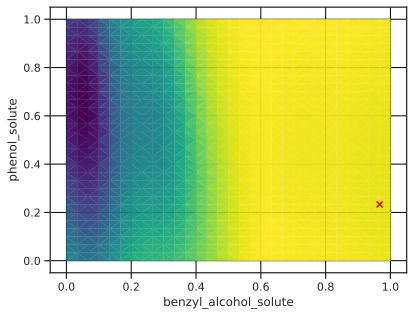

In [13]:
fig,ax = plt.subplots(1,1)
artists = plot_surface_mpl(dataset_out,'sans_comps_grid',labels='decision_surface',ternary=False, ax=ax)
ax.scatter(dataset_out.next_samples_xy[0][0],dataset_out.next_samples_xy[0][1],c='r',marker='x')

In [ ]:
# pline.write('GPC_GPC_pipeline.pkl')

In [ ]:
# def label_items(arr):
#     return np.unique(arr, return_inverse=True)
# def label_key(arr):
#     return np.unique(arr)

# best_fits = []
# chisqs = []
# X = []

# report_json =
# for idx in range(33):
    
#     fit_method= report_json['fit_method']
#     model_starts = report_json['model_inputs']
#     fit_results = report_json['best_fits']['model_idx'][idx]
#     empty_data = sasmodels.data.empty_data1D(np.logspace(np.log10(dataset.sans_q.values.min()),
#                                                          np.log10(dataset.sans_q.values.max()),
#                                                          1000
#                                                         ))
#     q = dataset.sans_q.values
#     # bf = report_json['best_fits'][f'data_{str(idx+1).zfill(3)}']
#     # best_fits.append(bf['model_name'])
#     # chisqs.append(bf['lowest_chisq'])
#     # best_fits.append(report_json['best_fits'][idx])
#     best_fits.append(fit_results)
#     # X.append([dataset.benzyl_alcohol_solute.values[idx],dataset.phenol_solute.values[idx]])
#     X.append(dataset.sans_comps.values[idx])
    
#     fig,ax = plt.subplots(1,2,figsize=(12.8,4.8))
#     ax[0].scatter(q,dataset.sans[idx].values,label='raw data',color='k',marker='s',facecolors='none')
#     for mdx in range(len(model_starts)):
#         init_model = model_starts[mdx]
#         fit_model = report_json['model_fits'][idx][mdx]
#         # print(init_model)
#         # print(fit_model)
#         # print()
#         init_model = sas_wrapper(
#             name=init_model['name'],
#             sasmodel_type=init_model['sasmodel'],
#             parameters=init_model['fit_params'],
#             empty_data = empty_data,
#             resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
#             )
        
#         #fit model parameters are not the same format as the initialized model. rebuild an unbounded parameters
#         #dictionary this way
        
#         params_final = {}
#         for key in list(fit_model['output_fit_params']):
#             print(key, fit_model['output_fit_params'][key]['value'])
#             params_final[key] = {'value':fit_model['output_fit_params'][key]['value'], 'bounds':None}
#         fit_model = sas_wrapper(
#             name=fit_model['name'],
#             sasmodel_type=fit_model['sasmodel'],
#             parameters=params_final,
#             empty_data = empty_data,
#             resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
#             )
        
        
#         ax[0].plot(init_model.model_q, init_model.model_I, label=f'{init_model.name}_initial')
#         ax[0].plot(fit_model.model_q, fit_model.model_I, label=f'{fit_model.name}_final')
#         ax[0].set(
#             xscale='log',
#             yscale='log',
#             ylim= (1e1,1e4)
#             )
#         ax[0].legend()
#     _, clss = label_items(best_fits)
#     key = label_key(best_fits)
#     ax[1].scatter(np.array(X)[:,0],np.array(X)[:,1],c=clss,cmap='viridis')
#     plt.show(fig)
#     plt.close(fig)

# Mono-modal

## load dataset

In [ ]:
dataset=xr.load_dataset('regressor_and_classifier_data.nc')
# display(dataset)
# dataset['sans_fit_values'] = dataset.sans_fit_values.dropna(dim='sans_sample')#.swap_dims({'sans_sample':'saxs_sample'})
# dataset['sans_fit_err_values'] = dataset.sans_fit_err_values.dropna(dim='sans_sample')#.swap_dims({'sans_sample':'saxs_sample'})
# display(dataset)
dataset['sans_comps'] = xr.DataArray(
    np.array([ds_psi.benzyl_alcohol_solute,ds_psi.phenol_solute]).T,
    dims=['sans_sample','component'],
    coords={'component':['benzyl_alcohol_solute','phenol_solute']}
)


#mismatching the comps
dataset['saxs_comps'] = xr.DataArray(
    np.array([ds_psi.benzyl_alcohol_solute,ds_psi.phenol_solute]).T,
    dims=['saxs_sample','component'],
    coords={'component':['benzyl_alcohol_solute','phenol_solute']}
)

dataset['sans'] = xr.DataArray(
    ds_psi.SAS.values, 
    dims=['sans_sample','sans_q'],
    coords={'sans_q':ds_psi.q.values}
   )

dataset['saxs'] = xr.DataArray(
    ds_psi.SAS.values, 
    dims=['saxs_sample','saxs_q'],
    coords={'saxs_q':ds_psi.q.values}
   )

dataset['sans_err'] = xr.DataArray(
    0.1 * ds_psi.SAS.values, 
    dims=['sans_sample','sans_q']
   )

dataset['saxs_err'] = xr.DataArray(
    0.1 * ds_psi.SAS.values, 
    dims=['saxs_sample','saxs_q']
   )

dataset = dataset.drop_vars(['sans_labels','sans_label_names','sans_best_chisq','sans_fit_values','sans_fit_err_values'])
# dataset = dataset.rename_vars(
#     {'sans_fit_values':'rg',
#     'sans_fit_err_values':'rg_err'}
# )
dataset

## Build Pipeline

In [ ]:
with Pipeline() as pline:
    # data preprocessing step (tbd, background suptraction etc.)
    Standardize(input_variable='sans_comps',
                    output_variable='sans_comps_standardized',
                    dim='sans_sample',
               )

    # run saxs classifier
    SASfit.SASfit_classifier(
        sas_variable='sans',
        sas_err_variable='sans_err',
        input_models=initial_models,
        resolution=None,
        output_prefix='sans',
        q_dim = 'sans_q',
        sample_dim='sans_sample'
    )
    # need to build grid object
    grid_spec = {
        'benzyl_alcohol_solute':{'min':0,'max':1,'steps':31},
        'phenol_solute':{'min':0,'max':1,'steps':31}
    }
    CartesianGrid(grid_spec=grid_spec, output_variable='sans_comps_grid',sample_dim='grid')

    #kernel needs to have the length scales in accordance with the input dimensions. if you standardize the inputs, your values should be between 0-1
    kernel = gaussian_process.kernels.Matern(length_scale=[0.3,0.1], nu=2.5,length_scale_bounds=[(1e-1,1e0),(1e-1,1e0)])
    # kernel = gaussian_process.kernels.Matern(length_scale=(3.,.1), nu=2.5, length_scale_bounds=[(1e-3,1e1),(1e-3,1e1)])
    
    # build GPC from saxs data
    GaussianProcessClassifier(
        kernel=kernel,
        optimizer=None,
        feature_input_variable='sans_comps_standardized',
        predictor_input_variable='sans_labels',
        output_prefix='sans_labels_extrap',
        sample_dim='sans_sample',
        grid_variable='sans_comps_grid',
        grid_dim='grid',
    )

    MaxValueAF(
        input_variables=['sans_labels_extrap_entropy'],
        output_variable='next_samples_xy',
        grid_variable='sans_comps_grid',
        grid_dim='grid',
        decision_rtol=0.05,
        # excluded_comps_variables=['sans_sample'],
        exclusion_radius=1e-3,
        count=1,
    )

pline
    

In [ ]:
pline.draw(edge_labels=True)
# pline.write('monomodal_SANS_MaxValueAF.pkl')

In [ ]:
dso = pline.calculate(dataset)

## plotting

In [ ]:
fig,ax = plt.subplots(1,1)
artists = plot_surface_mpl(dso,'sans_comps_grid',labels='decision_surface',ternary=False, ax=ax)
ax.scatter(dso.next_samples_xy[0][0],dso.next_samples_xy[0][1],c='r',marker='x')

In [ ]:
dso.next_samples_xy

# SAXS and SANS input models

In [ ]:
SANS_initial_models = [
    {'name':"latex_sphere_1",
     'sasmodel':'sphere',
     'fit_params':{
           "scale"                           : {'value':1e-7,         'bounds':(1e-10,1e6)},
            "background"                     : {'value':1e-3,         'bounds':(1e-4,1e1)},
            "radius"                         : {'value':500,          'bounds':(1e0,1e4)},
            "radius_pd"                      : {'value':0.03,         'bounds':(1e-3,0.2)},
            "radius_pd_type"                 : {'value':'gaussian',   'bounds':None},
            "radius_pd_n"                    : {'value':15,           'bounds':None},
            "sld"                            : {'value':0.655,        'bounds':None},
            "sld_solvent"                    : {'value':2.74,         'bounds':None},
     }
    },
    {'name':"power_law_1",
     'sasmodel':'power_law',
     'fit_params': {
            "scale"                          : {'value':1e-6,         'bounds':(1e-12,1e7)},
            "background"                     : {'value':1e-3,         'bounds':(1e-10,1e1)},
            "power"                          : {'value':4,            'bounds':(3.75,4.25)}
        },
    },
    {'name':"guinier_porod_1",
     'sasmodel':'guinier_porod',
     'fit_params':{
            "scale"                         : {"value" : 1e-4,           'bounds': (1e-10,1e1)},
            "background"                    : {"value" : 1e-3 ,       'bounds': (1e-4,1e1)},
            "rg"                            : {"value" :1500 ,        'bounds': (1e0,1e4)},
            "s"                             : {"value" : 0 ,          'bounds': None},
            "porod_exp"                     : {"value" : 4 ,          'bounds': (3.8,4.2)}
        },
    },
    {'name':"raspberry_1",
    'sasmodel':'raspberry',
    'params':{
            "scale"                         : {'value':1e-7,        'bounds':(1e-5,1e6)},
            "background"                    : {'value':1e-3,          'bounds':(1e-4,1e1)},
            "sld_lg"                        : {'value':2.74,          'bounds':None},
            "sld_sm"                        : {'value':0.655,         'bounds':None},
            "sld_solvent"                   : {'value':2.74,           'bounds':(1.4,1.6)},
            "volfraction_lg"                : {'value':0.4,           'bounds':(0.2,1.0)},
            "volfraction_sm"                : {'value':0.1,           'bounds':(0.2,1.0)},
            "surface_fraction"              : {'value':0.4,           'bounds':(0.2,1.0)},
            "radius_lg"                     : {'value':1500,          'bounds':(1e0,1e4)},
            "radius_sm"                     : {'value':500,           'bounds':(1e0,1e4)},
            "radius_sm_pd"                  : {'value':0.10,          'bounds':(1e-2,1e0)},
            "radius_sm_pd_type"             : {'value':'gaussian',    'bounds':None},
            "radius_sm_pd_n"                : {'value':15,            'bounds':None},
            "radius_lg_pd"                  : {'value':0.03,          'bounds':(1e-3,1e0)},
            "radius_lg_pd_type"             : {'value':'gaussian',    'bounds':None},
            "radius_lg_pd_n"                : {'value':15,            'bounds':None},
            "penetration"                   : {'value':0,             'bounds':None}
        }
    }
]



In [ ]:
saxs_initial_models = [
    {'name':"TiO2_sphere_1",
     'sasmodel':'sphere',
     'fit_params':{
           "scale"                           : {'value':1e3,         'bounds':(1e-10,1e7)},
            "background"                     : {'value':1e-3,         'bounds':(1e-4,1e1)},
            "radius"                         : {'value':1500,          'bounds':(1e0,1e4)},
            "radius_pd"                      : {'value':0.15         'bounds':(1e-3,0.5)},
            "radius_pd_type"                 : {'value':'gaussian',   'bounds':None},
            "radius_pd_n"                    : {'value':15,           'bounds':None},
            "sld"                            : {'value':0.655,        'bounds':None},
            "sld_solvent"                    : {'value':2.74,         'bounds':None},
     }
    },
    {'name':"power_law_1",
     'sasmodel':'power_law',
     'fit_params': {
            "scale"                          : {'value':1e-1,         'bounds':(1e-12,1e7)},
            "background"                     : {'value':1e-3,         'bounds':(1e-10,1e1)},
            "power"                          : {'value':4,            'bounds':(3.75,4.25)}
        },
    },
    {'name':"guinier_porod_1",
     'sasmodel':'guinier_porod',
     'fit_params':{
            "scale"                         : {"value" : 1e4,           'bounds': (1e-10,1e10)},
            "background"                    : {"value" : 1e-3 ,       'bounds': (1e-4,1e1)},
            "rg"                            : {"value" :1500 ,        'bounds': (1e0,1e4)},
            "s"                             : {"value" : 0 ,          'bounds': None},
            "porod_exp"                     : {"value" : 4 ,          'bounds': (3.8,4.2)}
        },
    }
]

# MaskGrid PipelineOp

In [ ]:
from AFL.double_agent import MaskGrid
dso = dataset_out
mask = dso.grid.where(dso.saxs_labels_extrap_mean==2).to_masked_array().mask
dso['mask'] = xr.DataArray(mask,dims=['grid'])
dso

In [ ]:
with Pipeline() as pline1:
    MaskGrid.MaskGrid(
        input_variable='sans_comps_grid',
        output_variable='masked_comps_grid',
        mask_variable='mask',
        grid_dim_in='grid',
        grid_dim_out = 'gpc_mask',
        output_prefix='sans'
    )
pline1.calculate(dso)

# Run Agent

In [ ]:
from tiled.client import from_uri
from tiled.queries import Eq
tiled_client = from_uri('http://localhost:8000',api_key='NistoRoboto642')


In [ ]:
agent_client = AgentClient.AgentClient('localhost',5053)
agent_client.login('')
agent_client.pause(False)

In [ ]:
pline.search("MaxValueAF").exclusion_radius

In [ ]:
agent_client.set_driver_object(pipeline=pline)
ds = starting_input.copy()
series='test1'
results = [ds.copy()]
for i in tqdm(range(100)):
    agent_client.set_driver_object(input=ds)
    al_uuid = agent_client.enqueue(task_name="predict",deposit=False,interactive=True)['return_val']
    
    result = agent_client.get_driver_object("results")[al_uuid]
    results.append(result)
    agent_client.enqueue(task_name="reset_results")
    
    next_samples = result['next_samples_bary']
    sample_composition = {}
    for sample in next_samples.transpose("AF_sample",...):
        for comp,value in zip(sample.component.values,sample.values):
            sample_composition[comp] = {'value':value}
    
    sans_sample_dict = sans_client.enqueue(task_name='set_sample', sample_name=f'series_{series}_sample_{i}', sample_composition=sample_composition, interactive=True)['return_val']
    saxs_sample_dict = saxs_client.enqueue(task_name='set_sample', sample_name=f'series_{series}_sample_{i}', sample_composition=sample_composition, interactive=True)['return_val']
    
    sans_client.enqueue(task_name='expose')
    saxs_client.enqueue(task_name='expose',interactive=True)
    
    sans_result = tiled_client.search(Eq('sample_uuid',sans_sample_dict['sample_uuid'])).search(Eq('task_name','expose')).items()[-1][-1] #.metadata
    sans_result = xr.DataArray(sans_result[()],dims=['sans_q'],coords={'sans_q':sans_result.metadata['q']})
    sans_result = sans_result.groupby('sans_q',squeeze=True).mean()
    
    saxs_result = tiled_client.search(Eq('sample_uuid',saxs_sample_dict['sample_uuid'])).search(Eq('task_name','expose')).items()[-1][-1]#.metadata
    saxs_result = xr.DataArray(saxs_result[()],dims=['saxs_q'],coords={'saxs_q':saxs_result.metadata['q']})
    saxs_result = saxs_result.groupby('saxs_q',squeeze=True).mean()
    
    ds_sans = xr.Dataset()
    ds_sans['sans'] = sans_result
    ds_sans['sans_comps'] = next_samples.rename({'AF_sample':'sans_sample'})
    
    ds_saxs = xr.Dataset()
    ds_saxs['saxs'] = saxs_result
    ds_saxs['saxs_comps'] = next_samples.rename({'AF_sample':'saxs_sample'})
    
    ds = xr.concat([ds,ds_sans],dim='sans_sample',data_vars='minimal')
    ds = xr.concat([ds,ds_saxs],dim='saxs_sample',data_vars='minimal')
    
    


In [ ]:
from AFL.double_agent.plotting import plot_scatter_mpl,plot_surface_mpl
ds1 = results[-1]
plot_surface_mpl(ds1,'comps_grid_bary',labels='saxs_labels_extrap_mean')
plot_scatter_mpl(ds1,component_variable='saxs_comps',component_dim='component',ax=plt.gca())
plot_scatter_mpl(ds1,component_variable='next_samples_bary',component_dim='component',ax=plt.gca(),color='red',marker='x')



In [ ]:
plot_surface_mpl(ds1,'comps_grid_bary',labels='sans_labels_extrap_mean')
plot_scatter_mpl(ds1,component_variable='saxs_comps',component_dim='component',ax=plt.gca())


In [ ]:
resufrom
AFL.double_agent.plotting
import plot_scatter_mpl, plot_surface_mpl

ds1 = results[-1]
plot_surface_mpl(ds1, 'comps_grid_bary', labels='saxs_labels_extrap_mean')
plot_scatter_mpl(ds1, component_variable='saxs_comps', component_dim='component', ax=plt.gca())
plot_scatter_mpl(ds1, component_variable='next_samples_bary', component_dim='component', ax=plt.gca(), color='red',
                 marker='x')

lts1 = copy.deepcopy(results)

In [ ]:
pl(ds1, 'comps_grid_bary', labels='saxs_labels_extrap_mean')
plot_scatter_mpl(ds1, component_variable='saxs_comps', component_dim='component', ax=plt.gca())
plot_scatter_mpl(ds1, component_variable='next_samples_bary', component_dim='component', ax=plt.gca(), color='red',
                 marker='x')

plot_surface_mpl(ds1, 'comps_grid_bary', labels='sans_labels_extrap_mean')
plot_scatter_mpl(ds1, component_variable='saxs_comps', component_dim='component', ax=plt.gca())

ds1
from AFL.double_agent.plotting import plot_scatter_mpl, plot_surface_mpl

for ds1 in results[1:10]:
    plt.figure()
    fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection='ternary'), figsize=(16, 8))
    plot_surface_mpl(ds1, 'comps_grid_bary', labels='decision_surface', ax=axes[0])
    p